In [1]:
import pandas as pd
import numpy as np
folder = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/LDSR/LDSR_Annot/1000G_EUR_Phase3_baseline/'
#baseline.10.annot.gz
annonames = [x.replace('.bedL2', '') for x in pd.read_csv(folder+'baseline.21.l2.ldscore.gz',sep='\t').columns[3:]]

df=pd.concat([pd.read_csv(folder + 'baseline.{}.annot.gz'.format(chri),sep='\t') for chri in [1]])
#df=pd.concat([pd.read_csv(folder + 'baseline.{}.annot.gz'.format(chri),sep='\t') for chri in range(1, 23)])

del df['CHR']
del df['BP']
del df['SNP']
del df['CM']
annomat = df.values.astype(np.float32)

In [2]:
%load_ext autoreload
%autoreload 2
import precimed
import precimed.mixer
import precimed.mixer.libbgmg
import precimed.mixer.utils
import precimed.mixer.cli
import precimed.mixer.figures
import numpy as np
import numpy.matlib
from precimed.mixer.utils import UnivariateParams
from precimed.mixer.utils import AnnotUnivariateParams
from precimed.mixer.utils import _log_exp_converter
from precimed.mixer.utils import _arctanh_tanh_converter
from precimed.mixer.utils import _logit_logistic_converter
import scipy.optimize
import matplotlib.pyplot as plt
import statsmodels.api as sm

libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=False)

def perform_fit(bounds_left, bounds_right, parametrization):
    bounds4opt = [(l, r) for l, r in zip(parametrization.params_to_vec(bounds_left), parametrization.params_to_vec(bounds_right))]
    optimize_result = scipy.optimize.differential_evolution(lambda x: parametrization.calc_cost(x), bounds4opt,
        tol=0.01, mutation=(0.5, 1), recombination=0.7, atol=0, updating='immediate', polish=False, workers=1)  #, **global_opt_options)
    params = parametrization.vec_to_params(optimize_result.x)
    print(params)

    # Step 2. neldermead-fast
    optimize_result = scipy.optimize.minimize(lambda x: parametrization.calc_cost(x), parametrization.params_to_vec(params),
        method='Nelder-Mead', options={'maxiter':240, 'fatol':1e-7, 'xatol':1e-4, 'adaptive':True})
    params = parametrization.vec_to_params(optimize_result.x)
    print(params)
    return params

def do_plots(params, label, ylims=[7.3, 20, 50, 150], strat=True):
    data = {}
    trait_index = 1
    downsample_factor=50
    mask = np.isfinite(libbgmg.zvec1)
    data['qqplot'] = precimed.mixer.cli.calc_qq_plot(libbgmg, params, 1, downsample_factor, mask)
    for ylim in ylims:
        precimed.mixer.figures.make_qq_plot(data['qqplot'], ylim=ylim)
        plt.savefig(figures_folder + label + 'ylim={}.qq.png'.format(ylim) , bbox_inches='tight')

    if not strat: return
    mafvec = libbgmg.mafvec[libbgmg.defvec]
    tldvec = libbgmg.ld_tag_r2_sum
    maf_bins = np.concatenate(([-np.inf], np.quantile(mafvec, [1/3, 2/3]), [np.inf]))
    tld_bins = np.concatenate(([-np.inf], np.quantile(tldvec, [1/3, 2/3]), [np.inf]))
    data['qqplot_bins'] = []
    for i in range(0, 3):
        for j in range(0, 3):
            mask = np.isfinite(libbgmg.zvec1) & ((mafvec>=maf_bins[i]) & (mafvec<maf_bins[i+1]) & (tldvec >= tld_bins[j]) &  (tldvec < tld_bins[j+1]))
            data['qqplot_bins'].append(precimed.mixer.cli.calc_qq_plot(libbgmg, params, trait_index, downsample_factor, mask,
                title='maf \\in [{:.3g},{:.3g}); L \\in [{:.3g},{:.3g})'.format(maf_bins[i], maf_bins[i+1], tld_bins[j], tld_bins[j+1])))

    for ylim in ylims:            
        plt.figure(figsize=[12, 12])
        for i in range(0, 3):
            for j in range(0, 3):
                plt.subplot(3,3,i*3+j+1)
                precimed.mixer.figures.make_qq_plot(data['qqplot_bins'][i*3+j], ylim=ylim)
                plt.title(data['qqplot_bins'][i*3+j]['title'].replace(';', '\n'))
        plt.savefig(figures_folder + label + 'ylim={}.binqq.png'.format(ylim) , bbox_inches='tight')    

In [3]:
libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=True)
libbgmg.init_log('/home/oleksanf/github/mixer/src/build/lib/mixer.log')

# ToDo: optimize gaussian cost function to benefit from complete tag indices. 
# In this case we don't need to compute redundant Edelta2 and Edelta4 for undefined tag indices.
libbgmg.set_option('use_complete_tag_indices', 1)

bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin0 = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
#trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/SSGAC_EDU_2018_no23andMe.sumstats.gz'
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/GIANT_HEIGHT_2018_UKB.sumstats.gz'
trait2_file = ''
extract = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/LDSR/w_hm3.justrs'
exclude = ''
chr2use = [1] # range(1, 23)
_cost_calculator_sampling = 0
_cost_calculator_gaussian = 1
_cost_calculator_convolve = 2

libbgmg.init(bim_file, frq_file, chr2use, trait1_file, trait2_file, exclude, extract)
libbgmg.set_option('ld_format_version', 0)
libbgmg.set_option('seed', 123)
libbgmg.set_option('cubature_rel_error', 1e-5)
libbgmg.set_option('cubature_max_evals', 1000)
libbgmg.set_option('cost_calculator', _cost_calculator_gaussian)

for chr_label in chr2use: 
    libbgmg.set_ld_r2_coo_from_file(int(chr_label), plink_ld_bin0.replace('@', str(chr_label)))
    libbgmg.set_ld_r2_csr(int(chr_label))
libbgmg.set_weights_randprune(64, 0.1)

mafvec = libbgmg.mafvec[libbgmg.defvec]
hetvec = 2 * np.multiply(mafvec, 1-mafvec)


In [ ]:
## print('Useful categories:')
print([(annoname, beta) for annoname, beta in zip(annonames, betavec[1:]) if beta>0])

beta2 = np.multiply(hetvec, np.matmul(annomat, betavec[1:]))
h2_annot = np.matmul(beta2.reshape((1, len(beta2))), annomat); h2_annot = h2_annot / h2_annot[0][0]
annot_frac = np.sum(annomat, 0)/np.sum(annomat, 0)[0];

df['NNLS'] = np.divide(h2_annot, annot_frac).flatten()


mod_wls = sm.WLS(z2, A1, weights=w)
res_wls = mod_wls.fit()
#plt.plot(res_wls.fittedvalues, z2, '.')

beta2 = np.multiply(hetvec, np.matmul(annomat, res_wls.params[1:]))
h2_annot = np.matmul(beta2.reshape((1, len(beta2))), annomat); h2_annot = h2_annot / h2_annot[0][0]
annot_frac = np.sum(annomat, 0)/np.sum(annomat, 0)[0];
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')

df['WLS'] = np.divide(h2_annot, annot_frac).flatten()

def find_sig2_vec(params):
    return np.multiply(np.dot(params._annomat, np.array(params._sig2_annot).astype(np.float32)),
           np.multiply(np.power(np.float32(2.0) * params._mafvec * (1-params._mafvec), np.float32(params._s)),
                       np.power(params._tldvec, np.float32(params._l)))) * params._sig2_beta

def find_annot_enrich(params, annomat):
    sig2_vec = find_sig2_vec(params)
    h2_vec = params._pi * np.multiply(hetvec, sig2_vec)
    h2_annot = np.matmul(h2_vec.reshape((1, len(h2_vec))), annomat);
    h2_total = h2_annot[0][0]

    snps_annot = np.sum(annomat, 0)
    snps_total = snps_annot[0]

    return np.divide(np.divide(h2_annot, h2_total), np.divide(snps_annot, snps_total))



In [188]:
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')
df['NNLS_p7'] = find_annot_enrich(params7, annomat).flatten()
df['NNLS_p8'] = find_annot_enrich(params8, annomat).flatten()
df['NNLS_p10'] = find_annot_enrich(params10, annomat).flatten()
df['NNLS_p11'] = find_annot_enrich(params11, annomat).flatten()
df[['Category', 'Prop._SNPs', 'Prop._h2', 'Enrichment_std_error', 'Enrichment', 'NNLS_p7', 'NNLS_p8', 'NNLS_p10', 'NNLS_p11']][df['Prop._SNPs']>0.01].round(3)

/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,Category,Prop._SNPs,Prop._h2,Enrichment_std_error,Enrichment,NNLS_p7,NNLS_p8,NNLS_p10,NNLS_p11
0,baseL2_0,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
1,Coding_UCSC.bedL2_0,0.014,0.156,2.316,10.924,7.253,7.157,0.956,7.328
2,Coding_UCSC.extend.500.bedL2_0,0.064,0.231,0.574,3.631,3.767,3.101,0.983,3.153
3,Conserved_LindbladToh.bedL2_0,0.026,0.301,1.471,11.702,11.946,10.807,0.971,10.934
4,Conserved_LindbladToh.extend.500.bedL2_0,0.330,0.669,0.123,2.025,2.068,1.896,1.015,1.900
5,CTCF_Hoffman.bedL2_0,0.024,0.039,1.026,1.618,1.880,2.063,1.045,2.039
6,CTCF_Hoffman.extend.500.bedL2_0,0.071,0.108,0.397,1.530,1.672,1.663,1.043,1.644
7,DGF_ENCODE.bedL2_0,0.136,0.487,0.452,3.581,2.391,3.651,1.031,3.637
8,DGF_ENCODE.extend.500.bedL2_0,0.538,0.918,0.063,1.705,1.506,1.568,1.027,1.562
9,DHS_peaks_Trynka.bedL2_0,0.111,0.387,0.452,3.495,2.829,3.237,1.035,3.223


In [176]:
data['params3'].keys()

dict_keys(['params', 'optimize', 'annot_enrich', 'full_cost', 'qqplot', 'qqplot_bins'])

In [187]:
np.all(~np.isfinite(data['params3']['qqplot']['hv_logp']))


True

In [170]:
libbgmg.set_option('diag', 0)

0

In [80]:
libbgmg.set_weights_randprune(64, 0.1)


0

In [36]:
#idx0=(tag_pdf_convolve==0) & (libbgmg.weights>0)
idx=((tag_pdf_convolve>0) & (libbgmg.weights>0))
#print(np.sum(idx0), np.sum(idx))

In [11]:
print(np.dot(libbgmg.weights[idx], tag_pdf_convolve[idx]))
print(cost_gaussian)

1186.4207
17336.46220645369


In [43]:
tag_pdf_gaussian[idx].min()

1.1754944e-38

In [29]:
tag_pdf_gaussian[idx]

array([0.16240817, 0.16096343, 0.10743059, ..., 0.21106009, 0.2116424 ,
       0.19055355], dtype=float32)

In [30]:
tag_pdf_convolve[idx]

array([0.16240814, 0.16096346, 0.10743059, ..., 0.21106012, 0.21164232,
       0.19055364], dtype=float32)

In [ ]:
np.nonzero(np.abs(np.log(tag_pdf_gaussian)-np.log(tag_pdf_convolve))>60)

In [9]:
idx=((tag_pdf_convolve>0) & (libbgmg.weights>0))
np.max(np.abs(np.log(tag_pdf_gaussian[idx])-np.log(tag_pdf_convolve[idx])))

50.11847

In [74]:
np.min(tag_pdf_convolve[tag_pdf_convolve>0])

2.0659866e-11

In [52]:
#idx=(libbgmg.weights>0)
#idx=(tag_pdf_convolve>0) & (libbgmg.weights>0)
idx=((libbgmg.weights>0) & (np.abs(libbgmg.zvec1) < 10.45))
a=-np.sum(np.multiply(libbgmg.weights[idx], np.log(tag_pdf_gaussian[idx])))
b=-np.sum(np.multiply(libbgmg.weights[idx], np.log(tag_pdf_convolve[idx])))
print(a,b)

16770.205 16770.06


/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
np.dot(libbgmg.weights[idx], tag_pdf_gaussian[idx],cost_gaussian,cost_convolve)

TypeError: matrixproduct() takes at most 3 arguments (4 given)

In [34]:
a=np.abs(np.log(tag_pdf_gaussian)-np.log(tag_pdf_convolve))
idx = (a<0.01) & (a>0.001)
print(tag_pdf_gaussian[idx])
print(tag_pdf_convolve[idx])
print(libbgmg.zvec1[idx])


[1.7355818e-15 7.7725946e-15 3.2065870e-15 6.3927813e-15 1.2732968e-14
 6.4004287e-15 6.4921624e-15 7.2407172e-15]
[1.7515170e-15 7.7827589e-15 3.2165242e-15 6.3835359e-15 1.2711976e-14
 6.4108921e-15 6.4771657e-15 7.2322832e-15]
[-23.675 -15.184  17.072  23.526  23.251  23.518  23.514  23.463]


/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [13]:
np.min(tag_pdf_gaussian[idx])

1.1754944e-38

In [12]:
np.min(tag_pdf_convolve[idx])

8.673067e-19

In [11]:
libbgmg.set_option('aux_option', 2)
libbgmg.set_option('cost_calculator', _cost_calculator_gaussian)

sig2_vec=params3.find_sig2_vec()
pi_vec = params3._pi * np.ones(shape=(libbgmg.num_snp, 1), dtype=np.float32)
tag_pdf_gaussian = libbgmg.calc_unified_univariate_Ezvec2(1, pi_vec, sig2_vec, params3._sig2_zeroA, 1, 0)
cost_gaussian = libbgmg.calc_unified_univariate_cost(1, pi_vec, sig2_vec, params3._sig2_zeroA, 1, 0)

libbgmg.set_option('cost_calculator', _cost_calculator_convolve)
libbgmg.set_option('cubature_rel_error', 1e-9)

tag_pdf_convolve = libbgmg.calc_unified_univariate_Ezvec2(1, pi_vec, sig2_vec, params3._sig2_zeroA, 1, 0)
cost_convolve = libbgmg.calc_unified_univariate_cost(1, pi_vec, sig2_vec, params3._sig2_zeroA, 1, 0)

print(np.nonzero((tag_pdf_convolve==0) & (libbgmg.weights>0)))

idx=((tag_pdf_convolve>0) & (libbgmg.weights>0))
np.max(np.abs(np.log(tag_pdf_gaussian[idx])-np.log(tag_pdf_convolve[idx])))

(array([538262]),)


50.11847

In [6]:
libbgmg.zvec1[(tag_pdf_convolve==0) & (libbgmg.weights>0)]

array([27.693], dtype=float32)

In [7]:
tag_pdf_convolve[116049]

6.504482e-10

In [10]:
tag_pdf_gaussian[538395]

2.5604272e-18

In [61]:
tag_pdf_gaussian[tag_pdf_gaussian>0].min()

1.1754944e-38

In [59]:
tag_pdf_convolve[tag_pdf_convolve>0].min()

2.785933e-10

In [57]:
np.nonzero((tag_pdf_convolve==0) & (libbgmg.weights>0))

(array([ 98499, 115943, 116049, 116074, 405443, 405579, 405582, 422751,
        422838, 422854, 425860, 499174, 499199, 499473, 499477, 499544,
        499545, 499612, 499637, 499651, 499733, 499737, 499761, 513194,
        513318, 538071, 538094, 538179, 538196, 538209, 538254, 538262,
        538395, 658693, 658721, 658732, 658742, 658770]),)

In [25]:
idx=((tag_pdf_gaussian != 0) | (tag_pdf_convolve != 0))
np.max(np.abs(tag_pdf_gaussian[idx] - tag_pdf_convolve[idx]))

1.7412007e-05

In [55]:
libbgmg.ld_tag_r2_sum[98499]

51.900333

In [53]:
libbgmg.mafvec[98499]

0.2372

In [52]:
np.nonzero(tag_pdf_convolve==1e-100)

(array([ 98499, 115943, 116049, 116074, 405443, 405579, 405582, 422751,
        422838, 422854, 425860, 499174, 499199, 499473, 499477, 499544,
        499545, 499612, 499637, 499651, 499733, 499737, 499761, 513194,
        513318, 538071, 538094, 538179, 538196, 538209, 538254, 538262,
        538395, 658693, 658721, 658732, 658742, 658770]),)

In [48]:
tag_pdf_convolve = tag_pdf_convolve.astype(np.float64)
tag_pdf_convolve[(tag_pdf_convolve<=0) & idx]=1e-100

(38,)

In [37]:
tag_pdf_gaussian[idx & (tag_pdf_gaussian==0)]

array([], dtype=float32)

In [38]:
tag_pdf_gaussian[idx & (tag_pdf_convolve==0)]

array([1.3648368e-09, 2.7026832e-08, 6.4867961e-10, 1.5176944e-08,
       1.7327101e-15, 1.5692145e-10, 1.4268707e-10, 1.9460981e-11,
       8.6939191e-15, 8.0767183e-15, 2.6020112e-14, 9.9690698e-13,
       8.9799874e-13, 5.3225446e-10, 4.7733278e-10, 2.4014339e-12,
       2.2727085e-12, 2.7929742e-12, 2.7114335e-12, 2.4634110e-12,
       2.4037946e-12, 5.9166592e-09, 1.7406645e-08, 1.0126087e-09,
       4.2284817e-10, 1.6631777e-14, 4.3795572e-09, 1.5734064e-24,
       1.9755140e-11, 1.0735530e-11, 8.2271723e-10, 1.0075949e-18,
       2.5387707e-18, 6.3821980e-15, 1.1759822e-12, 1.2904978e-09,
       6.4813187e-15, 4.2550941e-12], dtype=float32)

In [50]:
idx=libbgmg.weights>0
-np.sum(np.multiply(libbgmg.weights[idx], np.log(tag_pdf_convolve[idx])))

17989.09476996527

In [26]:
print(cost_gaussian, cost_convolve)

17336.462241622565 17989.09476918166


In [35]:
1*2.5857617479789346e-07, 5.905602509994463e-05*0.001053370968689902

(2.5857617479789346e-07, 6.220790236650385e-08)

In [ ]:
# +.-T indicate status (fitted, in progress, done, ToBeImplemente)
# number in parentheses indicate a dependency (e.g. params5 depend on params3)

# params1      + standard causal mixture model, fit using old implementation

# params3      + infinitesimal model (just to find baseline sig2beta)
# params4      + infinitesimal model, allowing for flexible S and L parameters

# params5 (3)  + baseline annotation model, infinitesimal, without accounting for S and L parameters
# params6 (4)  + baseline annotation model, infinitesimal, allowing for flexible S and L parameters

# params7 (5)  + causal mixture with annotation, without accounting for S and L parameters
# params8 (6)  + causal mixture with annotation, allowing for flexible S and L parameters
#               (note that here S and L are kept from infinitesimal model - need to re-fit them?)                  

# params9      - causal mixture without annotations, without accounting for S and L parameters
# params10     + causal mixture without annotations, allowing for flexible S and L parameters

# params11 (6) + causal mixture with annotations, allowing for flexible S and L parameters,
#                and re-fit S and L in the context of mixture model


Take home messages
1. Modeling annotations affects "pi" estimates in mixture model - they increase by a factor of 10

Technical issues
1. Fast const function is ~150 times faster, and gives high quality results  - however I'm not sure if we can trust it 100%
2. Why for infinitesimal cost function gaussian approximation doesn't give exactly the same answer as convolutions? 

TBD
- increase number of iterations in fminsearch
- split runs across parameters so that we can run 

In [294]:
params11

AnnotUnivariateParams(_pi: 0.015880541721926548, _sig2_beta: 2.2497055296175e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.365544728354278, _l: -0.13260565509183503, _sig2_zeroA: 1.8823111632885878)

In [ ]:
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')
df['NNLS_p7'] = find_annot_enrich(params7, annomat).flatten()
df['NNLS_p8'] = find_annot_enrich(params8, annomat).flatten()
df['NNLS_p10'] = find_annot_enrich(params10, annomat).flatten()
df['NNLS_p11'] = find_annot_enrich(params11, annomat).flatten()


UnivariateParams(_pi: 0.0014400133519476379, _sig2_beta: 0.0002144974094950297, _sig2_zero: 2.2960585139856797)
UnivariateParams(_pi: 0.0015684598531926141, _sig2_beta: 0.00020448806343576262, _sig2_zero: 2.23992429765977)


/home/oleksanf/github/mixer/precimed/mixer/cli.py:459: RuntimeWarning: divide by zero encountered in log10
  hv_logp = -np.log10(2*scipy.stats.norm.cdf(-hv_z))
/home/oleksanf/github/mixer/precimed/mixer/figures.py:50: RuntimeWarning: invalid value encountered in less
  y2[x2<np.nanmax(x1)]=interp1d(x1, y1)(x2[x2<np.nanmax(x1)])                #upper CI bound
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


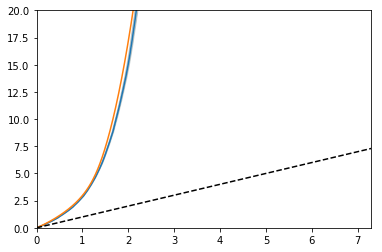

In [4]:
# params1 - standard causal mixture model, fit using old implementation
parametrization = precimed.mixer.utils.UnivariateParametrization_natural_axis(lib=libbgmg, trait=1)
bounds_left = UnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zero=0.9)
bounds_right = UnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zero=2.5)
params1=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params1, '_params1')



In [4]:
# params3 - infinitesimal model (just to find baseline sig2beta)
constraint = AnnotUnivariateParams(pi=1, sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(sig2_beta=5e-8, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(sig2_beta=5e-2, sig2_zeroA=2.5)
params3=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: 1, _sig2_beta: 3.326658501249406e-07, _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 2.1516625516482493)
AnnotUnivariateParams(_pi: 1, _sig2_beta: 3.369167984860813e-07, _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 2.04649596972114)


In [65]:
# params4 - infinitesimal model, allowing for flexible s and l parameters
constraint = AnnotUnivariateParams(pi=1, sig2_annot=[1], annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, sig2_beta=5e-8, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, sig2_beta=5e-2, sig2_zeroA=2.5)
params4=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: 1, _sig2_beta: 6.75500989148921e-07, _sig2_annot: [1], _s: -0.011335565551680804, _l: -0.16934948578635015, _sig2_zeroA: 2.054008709175631)
AnnotUnivariateParams(_pi: 1, _sig2_beta: 7.53163000205981e-07, _sig2_annot: [1], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 2.0661803442547924)


In [71]:
# params5 - baseline annotation model, infinitesimal, without accounting for S and L parameters
trait_index=1
params5 = AnnotUnivariateParams(pi=1.0, sig2_beta=params3._sig2_beta, sig2_annot=None, annomat=annomat, annonames=annonames, s=0, l=0, sig2_zeroA=0, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
params5.fit_sig2_annot(libbgmg, trait_index)
params5.drop_zero_annot()
print(params5)

AnnotUnivariateParams(_pi: 1.0, _sig2_beta: 2.9443784386506135e-07, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 2.3190660353261126)


In [76]:
#params6 - baseline annotation model, infinitesimal, allowing for flexible S and L parameters
trait_index=1
params6 = AnnotUnivariateParams(pi=1.0, sig2_beta=params4._sig2_beta, sig2_annot=None, annomat=annomat, annonames=annonames, s=params4._s, l=params4._l, sig2_zeroA=0, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
params6.fit_sig2_annot(libbgmg, trait_index)
params6.drop_zero_annot()
print(params6)

AnnotUnivariateParams(_pi: 1.0, _sig2_beta: 7.53163000205981e-07, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.7988296958524468)


AnnotUnivariateParams(_pi: 0.020112336745176665, _sig2_beta: 1.9934921745404774e-05, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 2.010107269906994)
AnnotUnivariateParams(_pi: 0.016490772435950134, _sig2_beta: 2.1573172356293674e-05, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 1.9785604206089915)


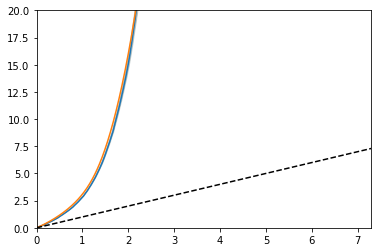

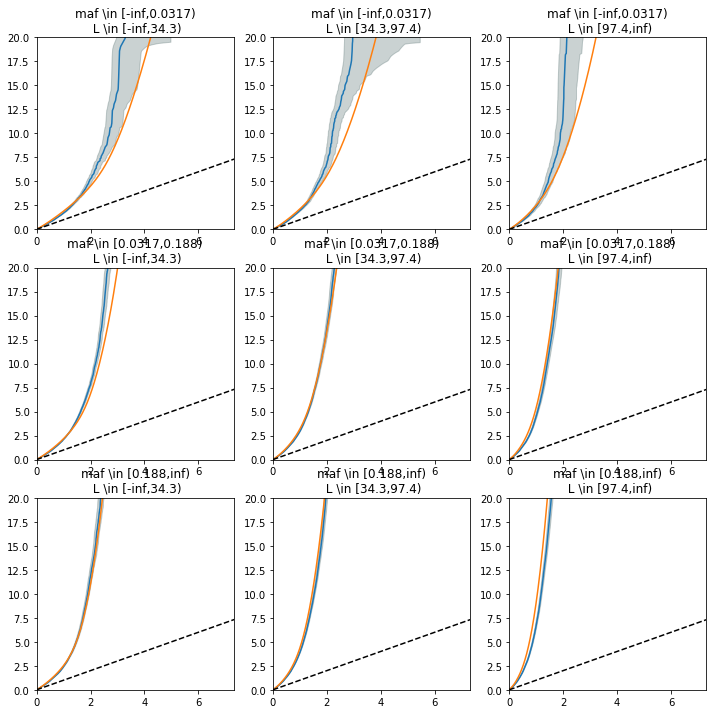

In [82]:
# params7 - causal mixture with annotation, without accounting for S and L parameters
constraint = AnnotUnivariateParams(s=0, l=0, sig2_annot=params5._sig2_annot, annomat=params5._annomat, annonames=params5._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params7=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params7, '_params7', True)

AnnotUnivariateParams(_pi: 0.015785388620568757, _sig2_beta: 4.874428472741427e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.886429562529495)
AnnotUnivariateParams(_pi: 0.015785512563498437, _sig2_beta: 4.5576351979317775e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.9063891647797888)


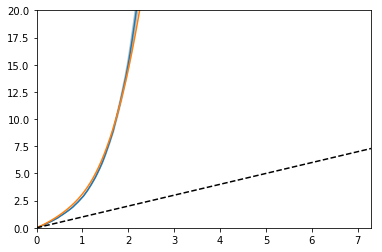

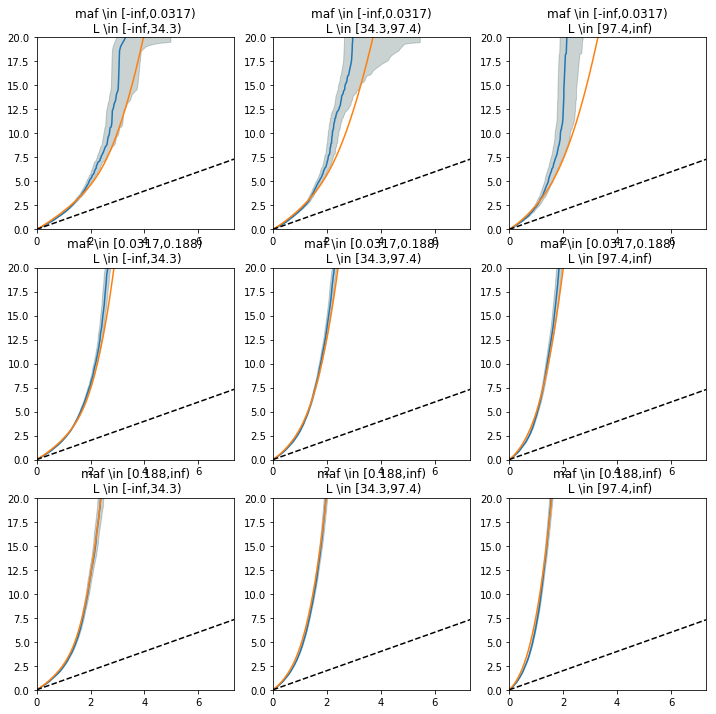

In [81]:
# params8 (6)  - causal mixture with annotation, allowing for flexible S and L parameters
constraint = AnnotUnivariateParams(s=params6._s, l=params6._l, sig2_annot=params6._sig2_annot, annomat=params6._annomat, annonames=params6._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params8=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params8, '_params8', True)

In [123]:
if 0:
    # params9 - causal mixture without annotations, without accounting for S and L parameters
    constraint = AnnotUnivariateParams(sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
    parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
    bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
    bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
    params9=perform_fit(bounds_left, bounds_right, parametrization)
    do_plots(params9, '_params9')

AnnotUnivariateParams(_pi: 0.0019422768605894315, _sig2_beta: 0.0001514049546435859, _sig2_annot: [1], _s: -0.6445122556819146, _l: -0.1664666397153803, _sig2_zeroA: 2.1554019231845993)
AnnotUnivariateParams(_pi: 0.0017433067614436263, _sig2_beta: 0.00032365469994769143, _sig2_annot: [1], _s: -0.4346094933177381, _l: -0.25205482692795367, _sig2_zeroA: 2.1819290510636007)


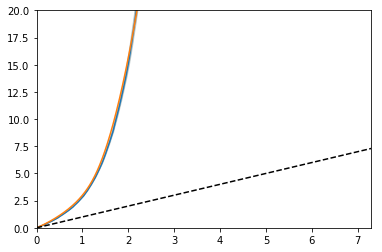

In [114]:
# params10 - causal mixture without annotations, allowing for flexible S and L parameters
constraint = AnnotUnivariateParams(sig2_annot=[1], annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params10=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params10, '_params10', True)

In [124]:
# params11  (6)  causal mixture with annotations, allowing for flexible S and L parameters,
#                and re-fit S and L in the context of mixture model
constraint = AnnotUnivariateParams(sig2_annot=params6._sig2_annot, annomat=params6._annomat, annonames=params6._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params11=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: 0.014591266436314046, _sig2_beta: 2.5377289052973313e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.4796922678191362, _l: -0.15359210045600655, _sig2_zeroA: 1.8451261379413293)
AnnotUnivariateParams(_pi: 0.015880541721926548, _sig2_beta: 2.2497055296175e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.365544728354278, _l: -0.13260565509183503, _sig2_zeroA: 1.8823111632885878)


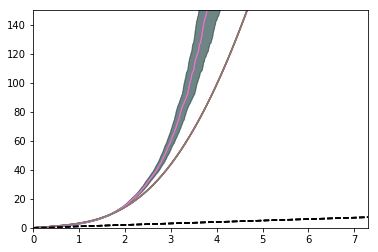

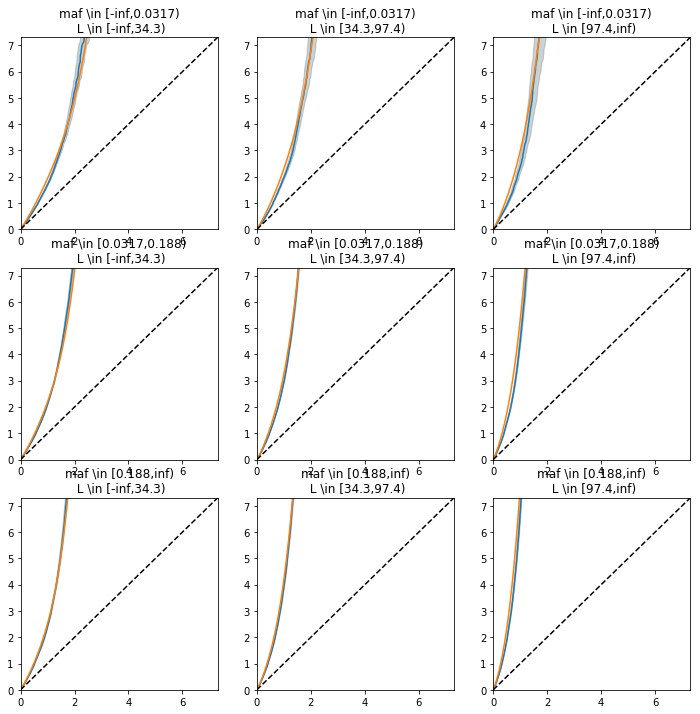

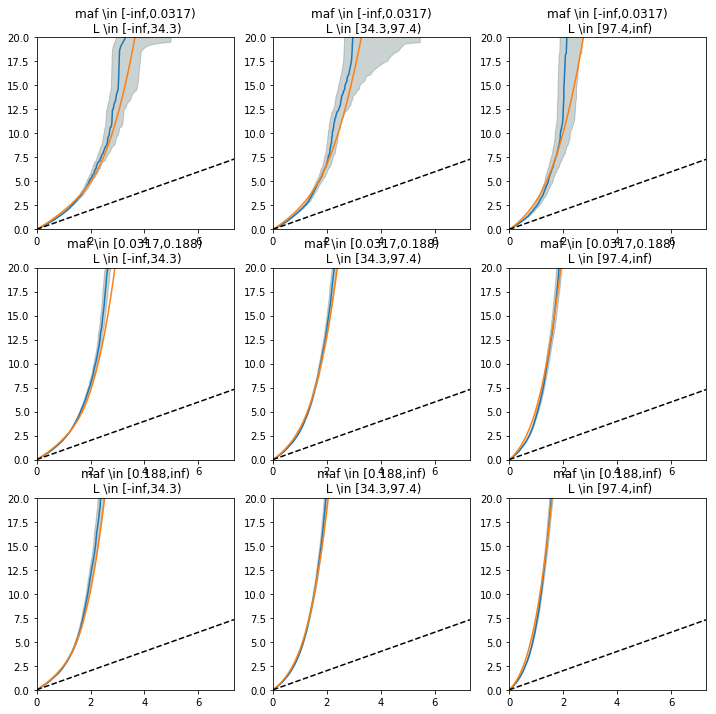

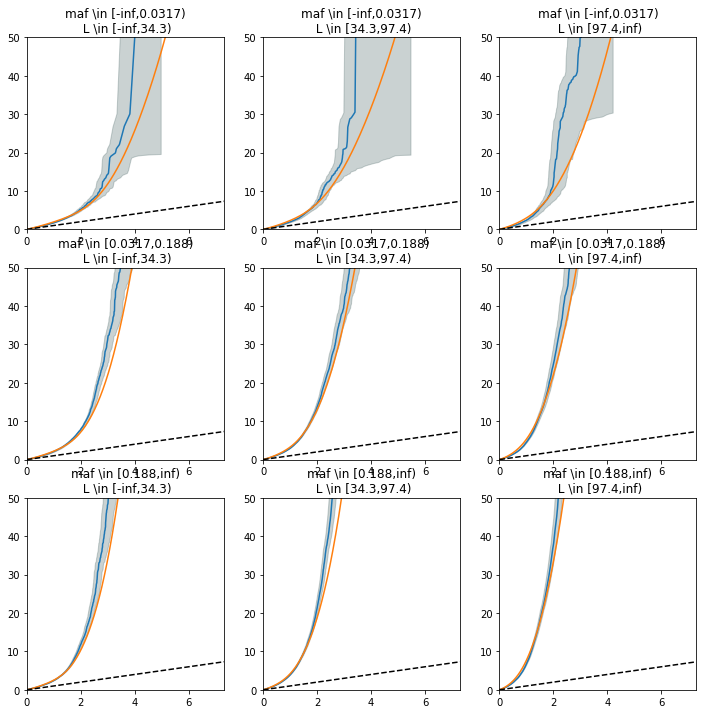

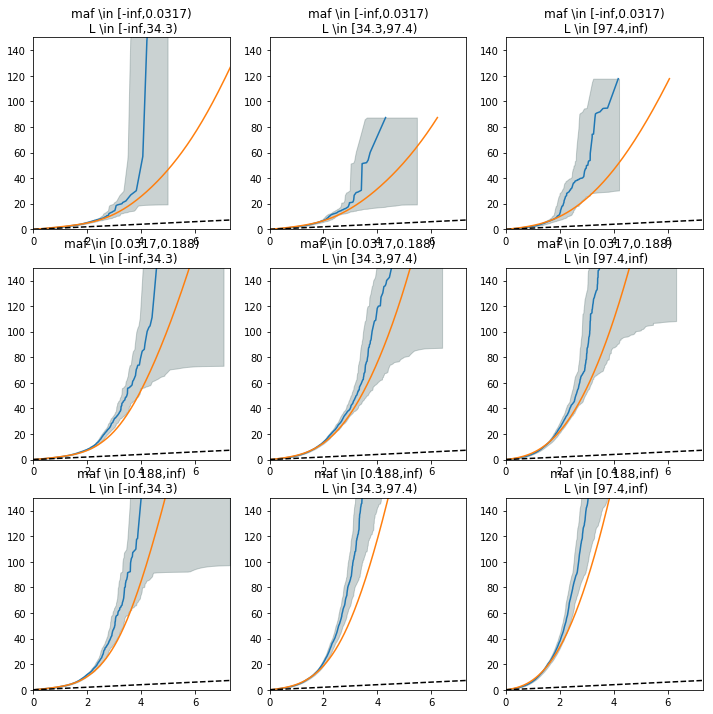

In [126]:
do_plots(params11, '_params11')

In [191]:
fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.outtag=run1.fit.json'
data = json.loads(open(fname).read())

'PGC_SCZ_2014_EUR'

In [232]:
data['params{}'.format(i)]['optimize']

[]

In [288]:
data['params{}'.format(i)]['optimize'][1][1]['nit']

237

In [321]:
data['params9']['optimize'][0][1]


{'x': [-3.611287917114037,
  -11.441519843353358,
  -0.0006768111904296159,
  -0.20978037638816333,
  0.12233096937770349],
 'fun': 136383.54458422825,
 'nfev': 375,
 'nit': 4,
 'message': 'Optimization terminated successfully.',
 'success': True,
 'cost_n': 90235.5,
 'cost_df': 5,
 'cost': 136383.54458422825,
 'BIC': 272824.14005937905,
 'AIC': 272777.0891684565,
 'cost_fast': 136383.54458422828,
 'params': {'pi': 0.026306310411193357,
  'sig2_beta': 1.074016781950545e-05,
  'sig2_zeroA': 1.130128077676214,
  's': -0.0006768111904296159,
  'l': -0.20978037638816333,
  'sig2_annot': [1.4456021758769357,
   0.06948736455566848,
   7.845566494188657,
   0.2936892404768628,
   3.1144300370726734,
   0.17838251850776796,
   2.8991067631487963,
   0.49249626754497927,
   0.6151179096485162,
   1.4422581020737424,
   1.5254774768733645],
  'annonames': ['Coding_UCSC.bed',
   'Coding_UCSC.extend.500.bed',
   'Conserved_LindbladToh.bed',
   'Conserved_LindbladToh.extend.500.bed',
   'H3K9ac_pe

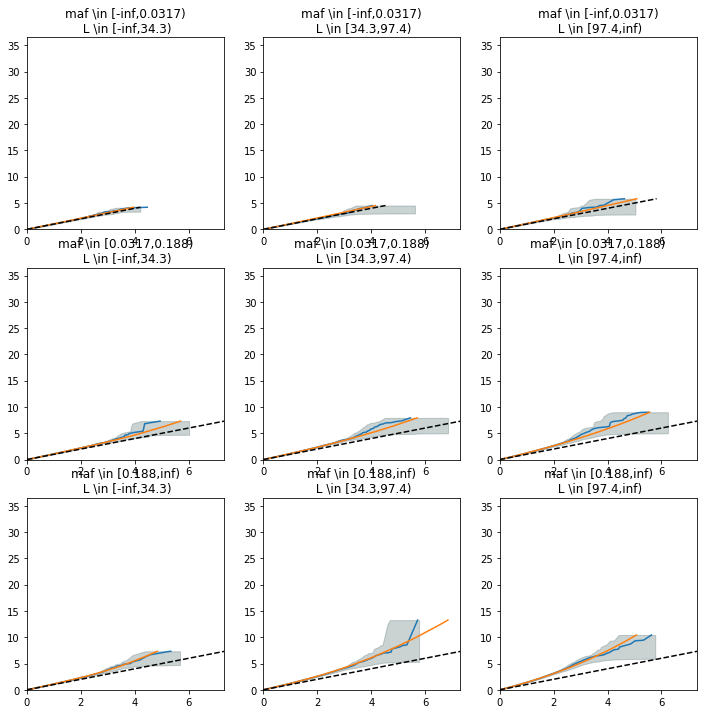

In [316]:
fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_BIP_2016.outtag=run1.fit.json'
data = json.loads(open(fname).read())
plt.figure(figsize=[12, 12])
kind='params4'
for i in range(0, 3):
    for j in range(0, 3):
        plt.subplot(3,3,i*3+j+1)
        precimed.mixer.figures.make_qq_plot(data[kind]['qqplot_bins'][i*3+j], ylim=5*7.3)
        plt.title(data[kind]['qqplot_bins'][i*3+j]['title'].replace(';', '\n'))


In [292]:
data.keys()

dict_keys(['options', 'analysis', 'params1', 'params2', 'params3', 'params4', 'params5', 'params6', 'params7', 'params8', 'params9'])

In [324]:
data['params{}'.format(i)]['optimize'][1]

['neldermead-fast',
 {'fun': 136417.18852992292,
  'nit': 240,
  'nfev': 459,
  'status': 2,
  'success': False,
  'message': 'Maximum number of iterations has been exceeded.',
  'x': [-13.793860398751464,
   -0.202889402491526,
   -0.38496044600190304,
   0.03356581323515803],
  'final_simplex': [[[-13.793860398751464,
     -0.202889402491526,
     -0.38496044600190304,
     0.03356581323515803],
    [-13.793881771848406,
     -0.20289308315533205,
     -0.3849567903410153,
     0.03356671316207557],
    [-13.79388688400206,
     -0.20289620482903098,
     -0.3849562195305184,
     0.03356673241704861],
    [-13.793862174492531,
     -0.20289756557690156,
     -0.3849615499494394,
     0.03356667376397722],
    [-13.793900229611612,
     -0.20289195068388086,
     -0.3849538197602801,
     0.033568137688573516]],
   [136417.18852992292,
    136417.18854532,
    136417.1885717852,
    136417.18857181226,
    136417.18858768116]],
  'cost_n': 90235.5,
  'cost_df': 4,
  'cost': 136417.18

In [326]:
data['params{}'.format(i)]['full_cost']

136417.0305318718

In [327]:
def insert_key_to_dictionary_as_list(key, value, df_data):
    if key not in df_data:
        df_data[key] = []
    df_data[key].append(value)

df_final=None
traits=['CARDIOGRAM_CAD_2015', 'GIANT_BMI_2015_EUR', 'GIANT_HEIGHT_2018_UKB', 'IIBDGC_CD_2017', 'IIBDGC_UC_2017', 'LIPIDS_HDL_2013', 'LIPIDS_LDL_2013', 'LIPIDS_TG_2013', 'PGC_BIP_2016', 'PGC_SCZ_2014_EUR', 'SSGAC_EDU_2018_no23andMe', 'UKB_HEIGHT_2018_irnt' ]
for trait in traits:
    fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.outtag=run1.fit.json'.format(trait)
    data = json.loads(open(fname).read())
    df_data = {}
    for i in range(1, 10):
        p = data['params{}'.format(i)]['params']
        p['num_annot'] = len(p['annonames'])
        p['model'] = 'params{}'.format(i)
        p['fullcost'] = data['params{}'.format(i)]['full_cost']
        not_has_optimize = not data['params{}'.format(i)]['optimize']
        p['fastcost'] = np.nan if not_has_optimize else data['params{}'.format(i)]['optimize'][1][1]['fun']
        p['nit'] = np.nan if not_has_optimize else data['params{}'.format(i)]['optimize'][1][1]['nit']
        p['annots'] = ' '.join(p['annonames'])
        insert_key_to_dictionary_as_list('fname', fname.split('/')[-1].split('.')[0], df_data)  
        for k in ['model', 'pi', 'sig2_beta', 'sig2_zeroA', 's', 'l', 'num_annot', 'fullcost', 'fastcost', 'nit','annots']:
            insert_key_to_dictionary_as_list(k, p[k], df_data)  
    df=pd.DataFrame(df_data)        
    mincost = 0 # np.min([np.min(df['fullcost'].values), np.nanmin(df['fastcost'].values)])
    df['fullcost'] = df['fullcost'] - mincost
    df['fastcost'] = df['fastcost'] - mincost
    df_final = pd.concat([df_final, df]) if (df_final is not None) else df
df_final.to_csv('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined.csv',index=False,sep='\t')
df_final

,fname,model,pi,sig2_beta,sig2_zeroA,s,l,num_annot,fullcost,fastcost,nit,annots
0,CARDIOGRAM_CAD_2015,params1,1.000000,3.190300e-08,0.931729,0.000000,0.000000,1,142677.858266,142259.770946,49.0,base
1,CARDIOGRAM_CAD_2015,params2,1.000000,2.214803e-07,0.903487,-0.062309,-0.379819,1,142690.105506,142242.908921,228.0,base
2,CARDIOGRAM_CAD_2015,params3,0.000331,8.440960e-05,0.941892,0.000000,0.000000,1,142007.980791,142020.006935,103.0,base
3,CARDIOGRAM_CAD_2015,params4,0.000404,1.995192e-04,0.936226,-0.038527,-0.225106,1,142027.252159,142012.683656,240.0,base
4,CARDIOGRAM_CAD_2015,params5,1.000000,3.190300e-08,0.912515,0.000000,0.000000,10,142203.815582,NaN,NaN,Coding_UCSC.bed Conserved_LindbladToh.bed Enha...
5,CARDIOGRAM_CAD_2015,params6,1.000000,2.214803e-07,0.874831,-0.062309,-0.379819,13,142222.787414,NaN,NaN,Coding_UCSC.bed Conserved_LindbladToh.bed Cons...
6,CARDIOGRAM_CAD_2015,params7,0.005812,5.690202e-06,0.911193,0.000000,0.000000,10,141816.513019,141572.363161,122.0,Coding_UCSC.bed Conserved_LindbladToh.bed Enha...
7,CARDIOGRAM_CAD_2015,params8,0.005107,3.727530e-05,0.895732,-0.062309,-0.379819,13,141800.863172,141799.817518,124.0,Coding_UCSC.bed Conserved_LindbladToh.bed Cons...
8,CARDIOGRAM_CAD_2015,params9,0.004666,1.110516e-05,0.896230,-0.296061,-0.141774,13,141803.287370,141782.209960,240.0,Coding_UCSC.bed Conserved_LindbladToh.bed Cons...
0,GIANT_BMI_2015_EUR,params1,1.000000,6.400079e-08,0.764386,0.000000,0.000000,1,140896.341474,139869.078603,61.0,base


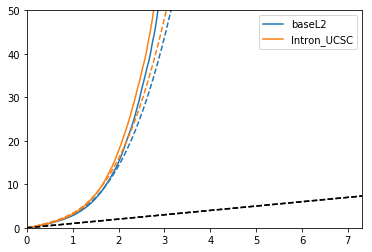

In [155]:
def make_qq_plot(qq, color, ylim=7.3, xlim=7.3):
    hv_logp = np.array(qq['hv_logp']).astype(float)
    data_logpvec = np.array(qq['data_logpvec']).astype(float)
    model_logpvec = np.array(qq['model_logpvec']).astype(float)
    ylim_data = max(hv_logp[np.isfinite(data_logpvec)])
    model_logpvec[hv_logp > ylim_data]=np.nan
    hData = plt.plot(data_logpvec, hv_logp, color=color, linestyle='solid')
    hModel = plt.plot(model_logpvec, hv_logp, color=color, linestyle='dashed')
    hNull = plt.plot(hv_logp, hv_logp, 'k--')
    plt.ylim(0, ylim); plt.xlim(0, xlim)
    return hData

cm = plt.cm.get_cmap('tab10')
legends_h = []; legends_n = []
trait_index = 1
downsample_factor=50
# nope, that's a bad definition - we need an LD-weighted definitions
annot_indices = [0, 31] # [0, 1, 3, 31, 47, 49]
for idx, annot_index in enumerate(annot_indices):
    mask = np.isfinite(libbgmg.zvec1) & (annomat[:, annot_index]>0)
    data_qqplot = precimed.mixer.cli.calc_qq_plot(libbgmg, params11, 1, downsample_factor, mask)
    h=make_qq_plot(data_qqplot, cm.colors[idx], ylim=50)
    legends_h.append(h[0])
    legends_n.append(annonames[annot_index])
plt.legend(legends_h, legends_n)
#plt.savefig(figures_folder + label + 'ylim={}.qq.png'.format(ylim) , bbox_inches='tight')


In [1]:
%load_ext autoreload
%autoreload 2
import precimed
import precimed.mixer
import logging
import numpy as np
#logging.getLogger().setLevel(logging.DEBUG)


In [58]:
np.power(np.array([1, 2,3]), 0.5)

array([1.        , 1.41421356, 1.73205081])

In [2]:
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')


In [2]:
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')
libbgmg.init_log("/home/oleksanf/github/mixer/testlog5.log")
libbgmg.log_message('Test log message succeeded?')
libbgmg.dispose()
libbgmg.defvec=[0, 1, 0, 1, 1, 0, 1, 1]
libbgmg.mafvec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
libbgmg.chrnumvec = [1, 1, 1, 2, 2, 2, 2, 2]
libbgmg.zvec1 = [-1.5, 1.5, 2.5, -2.5, 0.123]
libbgmg.zvec2 = [1.5, -1.5, -2.5, 2.5, 0.123]
libbgmg.nvec1 = [100, 200, 100, 200, 300]
libbgmg.nvec2 = [1000, 2000, 1000, 2000, 3000]
libbgmg.weights = [0.2, 0.2, 0.2, 0.3, 0.3]
print('num_snp: {}'.format(libbgmg.num_snp))
print('num_tag: {}'.format(libbgmg.num_tag))
print('defvec: {}'.format(libbgmg.defvec))
print('mafvec: {}'.format(libbgmg.mafvec))
print('chrnumvec: {}'.format(libbgmg.chrnumvec))
print('zvec1: {}'.format(libbgmg.zvec1))
print('zvec2: {}'.format(libbgmg.zvec2))
print('nvec1: {}'.format(libbgmg.nvec1))
print('nvec2: {}'.format(libbgmg.nvec2))
print('weights: {}'.format(libbgmg.weights))
libbgmg

num_snp: 8
num_tag: 5
defvec: [1 3 4 6 7]
mafvec: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
chrnumvec: [1 1 1 2 2 2 2 2]
zvec1: [-1.5    1.5    2.5   -2.5    0.123]
zvec2: [ 1.5   -1.5   -2.5    2.5    0.123]
nvec1: [100. 200. 100. 200. 300.]
nvec2: [1000. 2000. 1000. 2000. 3000.]
weights: [0.2 0.2 0.2 0.3 0.3]


LibBgmg(_lib_name: /home/oleksanf/github/mixer/src/build/lib/libbgmg.so, _context_id: 0, num_snp: 8, num_tag: 5)

In [2]:
from importlib import reload
import precimed.mixer
reload(precimed.mixer)
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')

libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')
libbgmg.init_log("/home/oleksanf/github/mixer/testlog5.log")
libbgmg.log_message('Test log message succeeded?')
libbgmg.dispose()

bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
chr_labels = list(range(1, 23))
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_SCZ_2014_EUR.sumstats.gz'
trait2_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_BIP_2016.sumstats.gz'
exclude = ''; extract = ''
libbgmg.init(bim_file, frq_file, chr_labels, trait1_file, trait2_file, exclude, extract);
print(libbgmg)

options=[('r2min', 0.05), ('kmax', 100), ('max_causals', 0.03*libbgmg.num_snp), ('num_components', 3), 
         ('cache_tag_r2sum', False), ('threads', 6), ('seed', None), ('z1max', None)]
for opt, val in options: libbgmg.set_option(opt, val)

for chr_label in chr_labels: 
    libbgmg.set_ld_r2_coo_from_file(plink_ld_bin.replace('@', str(chr_label)))
    libbgmg.set_ld_r2_csr(chr_label);

randprune_n = 64
randprune_r2 = 0.1
libbgmg.set_weights_randprune(randprune_n, randprune_r2);

libbgmg.set_option('diag', 0)

LibBgmg(_lib_name: /home/oleksanf/github/mixer/src/build/lib/libbgmg.so, _context_id: 0, num_snp: 9997231, num_tag: 1091550)


0

In [42]:
randprune_n = 64
randprune_r2 = 0.1
libbgmg.set_weights_randprune(randprune_n, randprune_r2);


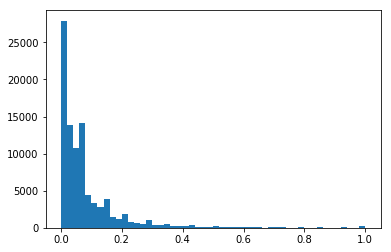

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(libbgmg.weights,bins=50);

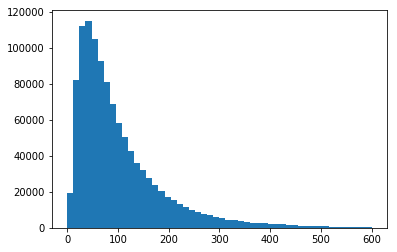

In [30]:
plt.hist(libbgmg.ld_tag_r2_sum, range=(0, 600), bins=50);

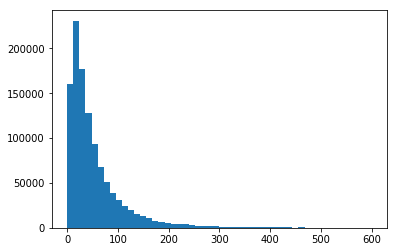

In [31]:
plt.hist(libbgmg.ld_tag_r4_sum, range=(0, 600), bins=50);

In [45]:
# it's possible to look at LD of a given SNP, and of the entire chromosome
for i in range(1,100):
    tag, r2 = libbgmg.get_ld_r2_snp(i)
    if len(tag>0):
        print(len(tag), list(zip(tag,r2)))
snp, tag, r2 = libbgmg.get_ld_r2_chr(21)

1 [(3450, 0.050812542)]
2 [(1627, 0.067566946), (1635, 0.065918975)]
4 [(2125, 0.05070573), (2128, 0.053543907), (4458, 0.05900664), (4465, 0.05159075)]
1 [(975, 0.06755169)]
1 [(975, 0.069092855)]
1 [(975, 0.069092855)]
12 [(1969, 0.05009537), (1971, 0.052048523), (3543, 0.051438164), (3579, 0.051819637), (3582, 0.051819637), (3585, 0.051544975), (3586, 0.0520943), (3589, 0.05168231), (3590, 0.05195697), (3591, 0.051422905), (3592, 0.052643627), (3594, 0.052109558)]


In [3]:
for i in range(1,100): libbgmg.calc_univariate_cost(1, 0.003, 1.2, 1e-4)

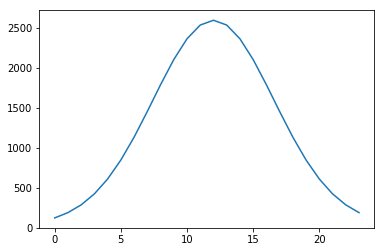

In [6]:
pdf=libbgmg.calc_univariate_pdf(1, 0.003, 1.2, 1e-4, np.arange(-3,3,0.25))
plt.plot(pdf);

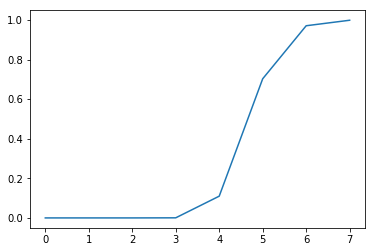

In [7]:
svec=libbgmg.calc_univariate_power(1, 0.003, 1.2, 1e-4, 5.45, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
plt.plot(svec)

In [3]:
c0,c1,c2=libbgmg.calc_univariate_delta_posterior(1, 0.003, 1.2, 1e-4)


RuntimeError: Disable calc_univariate_delta_posterior - for some reason it crashes in native c++ plugin

In [ ]:
out_file = '/home/oleksanf/github/mixer/results'
lib_name = '/home/oleksanf/github/mixer/src/build/lib/libbgmg.so'
log_file = out_file + '.log'
bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
chr_labels = list(range(1, 23))
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_SCZ_2014_EUR.sumstats.gz'
trait2_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_BIP_2016.sumstats.gz'
exclude = ''; extract = ''
    options=[('r2min', 0.05), ('kmax', 100), ('max_causals', 0.03*libbgmg.num_snp), ('num_components', 3), 
             ('cache_tag_r2sum', False), ('threads', 6), ('seed', 123), ('z1max', None), ('z2max', None)]
randprune_n = 64
randprune_r2 = 0.1

def setub_libbgmg(lib_name, log_file, bim_file, frq_file, plink_ld_bin, chr_labels,
                  trait1_file, trait2_file, exclude, extract,
                  options, randprune_n, randprune_r2):

    libbgmg = precimed.mixer.LibBgmg(lib_name)
    libbgmg.init_log(log_file)
    libbgmg.dispose()

    libbgmg.init(bim_file, frq_file, chr_labels, trait1_file, trait2_file, exclude, extract);

    for opt, val in options:
        libbgmg.set_option(opt, val)

    for chr_label in chr_labels: 
        libbgmg.set_ld_r2_coo_from_file(plink_ld_bin.replace('@', str(chr_label)))
        libbgmg.set_ld_r2_csr(chr_label);

    libbgmg.set_weights_randprune(randprune_n, randprune_r2);

    libbgmg.set_option('diag', 0)
    return libbgmg

In [ ]:
def run_mixer(lib):


In [157]:
x=scipy.optimize.minimize_scalar(lambda x:(x-1)*(x-1),  method='brent', bracket=[-10, 10])
print(x)
print(type(x))

     fun: 4.930380657631324e-32
    nfev: 9
     nit: 5
 success: True
       x: 1.0000000000000002
<class 'scipy.optimize.optimize.OptimizeResult'>


In [236]:
from importlib import reload
import precimed.mixer
reload(precimed.mixer)
from precimed.mixer.utils import *
from precimed.mixer.utils import UnivariateParams
from precimed.mixer.utils import BivariateParams
from precimed.mixer.utils import _log_exp_converter
from precimed.mixer.utils import _logit_logistic_converter
from precimed.mixer.utils import _arctanh_tanh_converter
from precimed.mixer.utils import UnivariateParametrization_constPI
from precimed.mixer.utils import UnivariateParametrization_constH2_constSIG2ZERO
from precimed.mixer.utils import UnivariateParametrization_constPI_constSIG2BETA
from precimed.mixer.utils import UnivariateParametrization
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO_boundedPI
from precimed.mixer.utils import BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_natural_axis
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRHOBETA_constPI
from precimed.mixer.utils import _hessian_robust
from precimed.mixer.utils import _max_rg
from precimed.mixer.utils import _calculate_univariate_uncertainty
from precimed.mixer.utils import _calculate_bivariate_uncertainty

print(UnivariateParams(0.001, 1e-4, 1.23).cost(libbgmg, 1))
print(UnivariateParams(0.001, 1e-4, 1.23).cost(libbgmg, 2))
print(BivariateParams([0.001, 0.002, 0.004], [1e-4, 3e-4], 0.8, [1.23, 1.06], 0.4).cost(libbgmg))

#scalar_optimizer = scipy.optimize.fminbound
params12_fitted, _ = BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO_boundedPI(
    const_params1=params[0],
    const_params2=params[1],
    const_rg=params12._rg(),
    const_rho_zero=params12._rho_zero,
    lib=libbgmg).fit(scalar_optimizer)
print(params12_fitted)

143039.9667054704
136117.94951642904
279813.56074795313
BivariateParams(_pi: [0.0012466754854858091, 0.0003354573743336747, 0.0028265604933306715], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8945159908412117, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)


In [85]:
import scipy.optimize

libbgmg.set_option('fast_cost', 1);
    
optimizer = lambda func, x0: scipy.optimize.minimize(func, x0, method='Nelder-Mead')

params = []

for trait in [1, 2]:
    params0, details = UnivariateParametrization_constPI(1.0, 1.5, 1e-4, libbgmg, trait=trait).fit(optimizer)
    #print(params0)

    params1, details = UnivariateParametrization_constH2_constSIG2ZERO(0.01, params0, libbgmg, trait=trait).fit(optimizer)
    #print(params1)

    params2, details = UnivariateParametrization_constPI_constSIG2BETA(1.0, params1, libbgmg, trait=trait).fit(optimizer)
    #print(params2)

    params3, details = UnivariateParametrization(params2, libbgmg, trait=trait).fit(optimizer)
    print(params3)
    
    params.append(params3)

alpha = 0.05
totalhet = 2.0 * np.dot(libbgmg.mafvec, 1.0 - libbgmg.mafvec) 
num_samples = 10000

# That's the most appropriate initialization for the bivariate model
# BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG - not used
# BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO    - used to fit the full model
zcorr = np.corrcoef(libbgmg.zvec1, libbgmg.zvec2)[0, 1]
params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.1,
    init_rho_beta=zcorr,
    init_rho_zero=zcorr,
    lib=libbgmg).fit(optimizer)
print(params12)

ci1, ci_sample1 = _calculate_univariate_uncertainty(UnivariateParametrization(params[0], libbgmg, trait=1), alpha, totalhet, libbgmg.num_snp, num_samples)
ci2, ci_sample2 = _calculate_univariate_uncertainty(UnivariateParametrization(params[1], libbgmg, trait=2), alpha, totalhet, libbgmg.num_snp, num_samples)
ci12, ci_sample12 = _calculate_bivariate_uncertainty(BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=params12._pi[2],
    init_rho_beta=params12._rho_beta,
    init_rho_zero=params12._rho_zero,
    lib=libbgmg), [ci_sample1, ci_sample2], alpha, totalhet, libbgmg.num_snp, num_samples)

print('\nUnivariate (trait1):')
for k, v in ci1.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))
print('\nUnivariate (trait2):')
for k, v in ci2.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))
print('\nBivariate:')
for k, v in ci12.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))

UnivariateParams(_pi: 0.004073235978816481, _sig2_beta: 5.288619957821589e-05, _sig2_zero: 1.1755915719572747)
UnivariateParams(_pi: 0.0031620178676643462, _sig2_beta: 5.231128193651721e-05, _sig2_zero: 1.084084668490775)
BivariateParams(_pi: [0.0012449932750385182, 0.00033377516388638376, 0.0028282427037779625], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8939839416846624, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)

Univariate (trait1):
pi: pe=0.00407, mean=0.0041, median=0.0041, std=0.000453, ci=[0.00329, 0.00506]
nc: pe=4.07e+04, mean=4.1e+04, median=4.1e+04, std=4.53e+03, ci=[3.29e+04, 5.06e+04]
nc@p9: pe=9.2e+03, mean=9.26e+03, median=9.26e+03, std=1.02e+03, ci=[7.43e+03, 1.14e+04]
sig2_beta: pe=5.29e-05, mean=5.32e-05, median=5.32e-05, std=5.34e-06, ci=[4.34e-05, 6.44e-05]
sig2_zero: pe=1.18, mean=1.18, median=1.18, std=0.00889, ci=[1.16, 1.19]
h2: pe=0.447, mean=0.447, median=0.447, st

In [144]:
# That's the most appropriate initialization for the bivariate model
# BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG - not used
# BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO    - used to fit the full model
zcorr = np.corrcoef(libbgmg.zvec1, libbgmg.zvec2)[0, 1]
params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.1,
    init_rho_beta=zcorr,
    init_rho_zero=zcorr,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0.0012449932750385182, 0.00033377516388638376, 0.0028282427037779625], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8939839416846624, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)


In [18]:
params12, details = BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG(
    const_sig2_beta=[p._sig2_beta for p in params],
    const_sig2_zero=[p._sig2_zero for p in params],
    max_rg=_max_rg(params[0]._pi, params[1]._pi),
    init_rho_beta=0.5, init_rho_zero=0.1, lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO(
    const_params1=params[0],
    const_params2=params[1],
    const_rg=params12._rho_beta,
    const_rho_zero=params12._rho_zero,
    init_pi12=min(params[0]._pi, params[1]._pi)*0.95,
    lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.5,
    init_rho_beta=0,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE_constRHOBETA_constPI(
    const_params1=params[0],
    const_params2=params[1],
    const_pi12=params12._pi[2],
    const_rho_beta=params12._rho_beta,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0, 0, 1], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8810739768325555, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.8528486201057031, rg: 0.8810739768325555)
BivariateParams(_pi: [0.0015524944994159688, 0.0006412763882638344, 0.002520741479400512], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 1.0, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.27, rg: 0.7023868342220096)
BivariateParams(_pi: [0.0015403841166866214, 0.0006291660055344869, 0.0025328518621298593], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.9999999995949107, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.2690626563807834, rg: 0.7057613066680437)
BivariateParams(_pi: [0.0015403841166866214, 0.0006291660055344869, 0.0025328518621298593], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.9999999995949107, _sig2_zero: [1.1755915719572747, 1

In [239]:
params12, details = BivariateParametrization_constUNIVARIATE_natural_axis(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.5,
    init_rho_beta=0,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0.0012389994058291652, 0.0003277812946770307, 0.0028342365729873155], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8928580429674069, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26906143314603836, rg: 0.7051257384792755)
